In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pydicom, torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import multiprocessing as mp

mp.set_start_method('fork', force=True)

Cohort Exploration

In [5]:
patient_df = pd.read_csv('/Users/jiwoo_noh/Downloads/admissions.csv')
dicom_df   = pd.read_csv('/Users/jiwoo_noh/Downloads/cxr-record-list.csv')

dicom_filtered = dicom_df[
    dicom_df['subject_id'].astype(str).str.startswith(('10', '12', '15', '17', '18', '19'))
]

merged = dicom_filtered.merge(
    patient_df[['subject_id', 'ethnicity']],
    on='subject_id',
    how='inner'
)

to_drop = ['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN', 'AMERICAN INDIAN/ALASKA NATIVE']

merged = merged[~merged['ethnicity'].isin(to_drop)]

result = merged[['subject_id', 'ethnicity', 'path']]

result.to_csv(
    '/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv',
    index=False
)

In [6]:
import pandas as pd

labels_df = pd.read_csv('/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv')

eth_df = labels_df[['subject_id','ethnicity']].drop_duplicates()
counts = eth_df['subject_id'].value_counts()
ambiguous_ids = counts[counts > 1].index.tolist()

if ambiguous_ids:
    print(f"Removing {len(ambiguous_ids)} patients with inconsistent ethnicity:", ambiguous_ids)

labels_df = labels_df[~labels_df['subject_id'].isin(ambiguous_ids)].reset_index(drop=True)
labels = labels_df['ethnicity']
subject_id = labels_df['subject_id']

Removing 214 patients with inconsistent ethnicity: [19919017, 18110020, 19014160, 19011622, 19936081, 18341991, 10942097, 15874847, 15057166, 10731206, 17183367, 15784514, 19565063, 10264068, 12604466, 12704996, 10949720, 18730486, 15506972, 15140950, 10056612, 12789108, 17102345, 17101277, 15574754, 17350899, 12034618, 15416392, 19299811, 19671332, 12297145, 12106493, 10270108, 15509202, 12697173, 10720865, 15966360, 17813449, 19763886, 18566742, 15071748, 17981662, 10367781, 15666867, 10827166, 12903377, 19821816, 10190829, 15608828, 17922113, 15853461, 19962126, 15800920, 17382149, 18905773, 12580408, 18532084, 19023015, 10253747, 17548885, 12125322, 18334912, 12021934, 18333592, 15677158, 15326328, 17720066, 17809813, 18728113, 12379909, 17447497, 12497543, 19575197, 18155258, 17930009, 15600427, 19674244, 18942108, 10756520, 18769702, 15393401, 12077819, 18767874, 12250460, 18962557, 19729296, 12673327, 12081472, 19151064, 19731136, 12847427, 10692049, 12450853, 17163115, 17852330

In [7]:
# calculate data demographics
race_counts = labels_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = labels_df['subject_id'].unique()

print(len(unique_subject))

ethnicity
WHITE                     969968
BLACK/AFRICAN AMERICAN    358786
HISPANIC/LATINO            91197
ASIAN                      38288
Name: count, dtype: int64
29955


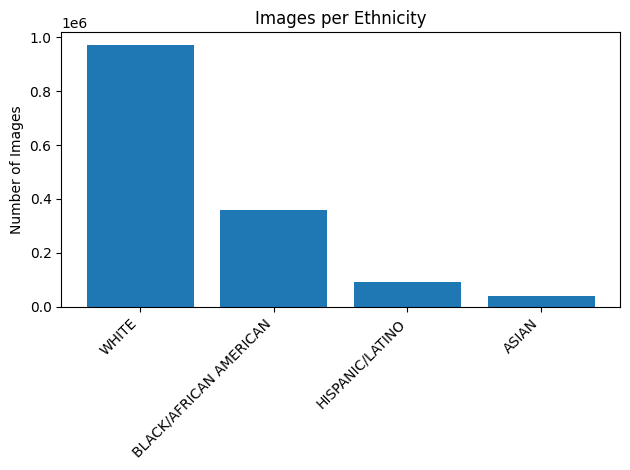

In [8]:
# plotting race distribution
plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DICOM Preprocessing

In [9]:
# preprocessing and generating model inputs
# need the local file structure that each patient id head is within
local_path_stem = '/Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/'

valid_rows = []
images_dict = {}
labels_dict = {}

for _, row in labels_df.iterrows():
    patient_id = row['subject_id']
    full_path  = os.path.join(local_path_stem, row['path'])
    if not os.path.exists(full_path):
        continue

    try:
        #img_tensor = preprocess_dicom_to_tensor(full_path, transform)
        #images_dict[(patient_id, full_path)] = img_tensor
        labels_dict[(patient_id, full_path)] = row['ethnicity']

        # record this row with full_path for your valid_df
        new_row = row.copy()
        new_row['path'] = full_path
        valid_rows.append(new_row)

    except Exception as e:
        print(f"error loading {full_path}: {e}")

# save the new list of patients (this is the data we will actually have access to)
valid_df = pd.DataFrame(valid_rows)
valid_df.to_csv('downloaded_data_info.csv', index=False)

ethnicity
WHITE                     10780
BLACK/AFRICAN AMERICAN     3527
HISPANIC/LATINO             813
ASIAN                       123
Name: count, dtype: int64
Number of unique patients:286


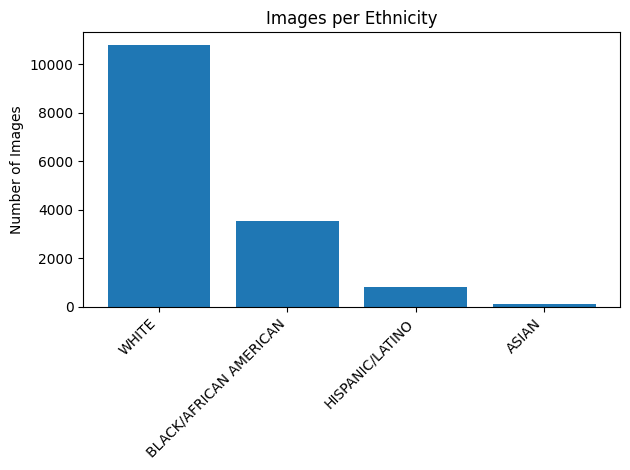

In [10]:
## plot the final patient demographics after filtering and downloading
race_counts = valid_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = valid_df['subject_id'].unique()

print(f'Number of unique patients:{len(unique_subject)}')

plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
import random
from sklearn.model_selection import train_test_split
from collections import Counter

# 0) Build patient->ethnicity map
patient_labels   = valid_df.groupby('subject_id')['ethnicity'].first()
unique_patients  = list(patient_labels.index)
n                = len(unique_patients)

# 1) Compute target sizes
n_test  = int(n * 0.10)
n_val   = int(n * 0.20)
n_train = n - n_val - n_test
print(f"Target: {n_train} train, {n_val} val, {n_test} test of {n} patients")

# 2) Reserve 1 patient per class for test
by_class     = patient_labels.groupby(patient_labels).groups  # dict: {eth: [pids]}
forced_test  = [ random.choice(pids) for pids in by_class.values() ]
assert len(forced_test) == len(by_class)

# 3) Remove forced_test from the pool
remaining = [pid for pid in unique_patients if pid not in forced_test]

# 4) From remaining, stratified‑sample exactly (n_test - len(forced_test)) extra test patients
extra_needed = n_test - len(forced_test)
if extra_needed > 0:
    extra_test, train_val = train_test_split(
        remaining,
        test_size=len(remaining) - extra_needed,
        stratify=[patient_labels[pid] for pid in remaining],
        random_state=42
    )
else:
    extra_test = []
    train_val  = remaining

p_test = forced_test + extra_test
print(f"Test set ({len(p_test)}): {Counter(patient_labels[pid] for pid in p_test)}")

# 5) Split the rest (train_val) into n_val and n_train
p_train, p_val = train_test_split(
    train_val,
    test_size=n_val,
    stratify=[patient_labels[pid] for pid in train_val],
    random_state=42
)
print(f"Train set ({len(p_train)}): {Counter(patient_labels[pid] for pid in p_train)}")
print(f" Val set ({len(p_val)}): {Counter(patient_labels[pid] for pid in p_val)}")

# 6) Build your image‐level lists exactly as before
train_items = [(pid, path) for (pid, path) in labels_dict.keys() if pid in p_train]
val_items   = [(pid, path) for (pid, path) in labels_dict.keys() if pid in p_val]
test_items  = [(pid, path) for (pid, path) in labels_dict.keys() if pid in p_test]

print(f"Image counts → train:{len(train_items)}, val:{len(val_items)}, test:{len(test_items)}")


Target: 201 train, 57 val, 28 test of 286 patients
Test set (28): Counter({'WHITE': 17, 'BLACK/AFRICAN AMERICAN': 7, 'ASIAN': 2, 'HISPANIC/LATINO': 2})
Train set (201): Counter({'WHITE': 137, 'BLACK/AFRICAN AMERICAN': 46, 'HISPANIC/LATINO': 13, 'ASIAN': 5})
 Val set (57): Counter({'WHITE': 39, 'BLACK/AFRICAN AMERICAN': 13, 'HISPANIC/LATINO': 3, 'ASIAN': 2})
Image counts → train:1566, val:302, test:180


In [12]:
import random
import pydicom
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import densenet121
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1) Smoke‑test filter ---
def filter_valid(items):
    good = []
    for pid, path in items:
        try:
            ds = pydicom.dcmread(path)
            _  = ds.pixel_array
            good.append((pid, path))
        except:
            print("Skipping corrupted:", path)
    return good

train_items = filter_valid(train_items)
val_items   = filter_valid(val_items)
test_items  = filter_valid(test_items)

print(f"Images → train:{len(train_items)}, val:{len(val_items)}, test:{len(test_items)}")

# --- 2) Dataset wrapper ---
label2idx = {
    'WHITE':                    0,
    'BLACK/AFRICAN AMERICAN':   1,
    'ASIAN':                    2,
    'HISPANIC/LATINO':          3,
}

class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx, transform):
        self.items = items
        self.labels= labels_dict
        self.l2i   = label2idx
        self.tx    = transform
    def __len__(self):
        return len(self.items)
    def __getitem__(self, i):
        pid, path = self.items[i]
        ds  = pydicom.dcmread(path)
        arr = ds.pixel_array.astype(np.float32)
        arr = (arr - arr.min())/(arr.ptp()+1e-6)
        img = Image.fromarray((arr*255).astype(np.uint8))
        img = self.tx(img)
        lbl = self.l2i[self.labels[(pid,path)]]
        return img, lbl

# --- 3) Compute mean/std on train set for normalization ---
stats_tx = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
stats_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, stats_tx),
    batch_size=32, shuffle=False, num_workers=4
)

def compute_mean_std(loader):
    m,v,n = 0,0,0
    for imgs,_ in loader:
        b,c,h,w = imgs.shape
        flat = imgs.view(b,c,-1)
        m += flat.mean(2).sum(0)
        v += flat.var(2, unbiased=False).sum(0)
        n += b
    mean = m/n
    std  = (v/n).sqrt()
    return mean, std

mean, std = compute_mean_std(stats_loader)
print("Dataset mean, std:", mean.tolist(), std.tolist())

# --- 4) Transforms (with augmentation in train) ---
train_tx = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tx = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- 5) Weighted sampler for train ---
train_labels = [ label2idx[labels_dict[(pid,path)]] for pid,path in train_items ]
counts      = np.bincount(train_labels, minlength=len(label2idx))
weights     = 1.0 / counts
sample_w    = [ weights[l] for l in train_labels ]
sampler     = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

# --- 6) DataLoaders ---
loader_kwargs = dict(batch_size=32, num_workers=8, pin_memory=True)
train_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, train_tx),
    sampler=sampler, **loader_kwargs
)
val_loader = DataLoader(
    DicomDataset(val_items, labels_dict, label2idx, val_tx),
    shuffle=False, **loader_kwargs
)
test_loader = DataLoader(
    DicomDataset(test_items, labels_dict, label2idx, val_tx),
    shuffle=False, **loader_kwargs
)

print("Loaders ready →",
      f"train={len(train_loader.dataset)},",
      f"val={len(val_loader.dataset)},",
      f"test={len(test_loader.dataset)}")


Skipping corrupted: /Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/files/p10/p10010440/s56908581/e0ceccb1-efe6919f-2b3c8cd2-c087f0b0-3d3adc66.dcm
Skipping corrupted: /Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/files/p12/p12020298/s59801417/ff37869a-3c0a2a97-1fe5c9f9-9cec4d83-55e3be6c.dcm
Skipping corrupted: /Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/files/p15/p15002645/s53705343/b4b0e6d0-b2cddde4-6834af95-8953a3d7-a3fdc7e9.dcm
Skipping corrupted: /Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/files/p15/p15002645/s54307277/0c0cc95f-fea4617e-1d7b37e3-73b319b9-af011678.dcm
Skipping corrupted: /Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/files/p15/p15002645/s56305168/d66be8ed-c967e624-208d531f-6332644f-0db95142.dcm
Skipping corrupted: /Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/files/p15/p15002645/s56314204/eda42a36-43a3a041-c5bac2d9-d086dcdf-8d4219a7.dcm
Skipping corrupted: /Users/j

In [13]:
# 7) Model + optimizer + scheduler + freeze logic
model = densenet121(pretrained=True)
model.features.conv0 = nn.Conv2d(1, model.features.conv0.out_channels,
                                 kernel_size=model.features.conv0.kernel_size,
                                 stride=model.features.conv0.stride,
                                 padding=model.features.conv0.padding,
                                 bias=False)
model.classifier = nn.Linear(model.classifier.in_features, len(label2idx))
model = model.to(device)

# freeze backbone 3 epochs
for p in model.features.parameters(): p.requires_grad=False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs, best_val_acc, freeze_epochs = 15, 0.0, 3

for ep in range(1, num_epochs+1):
    if ep == freeze_epochs+1:
        for p in model.features.parameters(): p.requires_grad=True

    # train
    model.train(); rloss=correct=total=0
    for imgs,labs in tqdm(train_loader, desc=f"Train {ep}"):
        imgs,labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        out  = model(imgs); loss = criterion(out, labs)
        loss.backward(); optimizer.step()
        rloss   += loss.item()*imgs.size(0)
        preds    = out.argmax(1)
        correct += (preds==labs).sum().item()
        total   += labs.size(0)
    train_loss, train_acc = rloss/total, correct/total

    # validate
    model.eval(); vloss=correct=total=0
    with torch.no_grad():
        for imgs,labs in tqdm(val_loader, desc=f"Val {ep}"):
            imgs,labs = imgs.to(device), labs.to(device)
            out  = model(imgs); loss = criterion(out, labs)
            vloss   += loss.item()*imgs.size(0)
            preds   = out.argmax(1)
            correct += (preds==labs).sum().item()
            total   += labs.size(0)
    val_loss, val_acc = vloss/total, correct/total
    scheduler.step(val_loss)

    print(f"Ep {ep}: Train {train_loss:.3f}/{train_acc:.3f} | Val {val_loss:.3f}/{val_acc:.3f}")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(),"best_densenet_ethnicity.pth")
        print("→ saved new best")
    print("-"*50)

print("Done, best val acc:", best_val_acc)

/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Train 1:  24%|██▍       | 12/49 [00:57<02:37,  4.25

In [ ]:
# 9) Evaluation: Classification Report, Confusion Matrix, ROC Curves

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)

# Reconstruct labels list in order of your classifier outputs:
unique_labels = [lab for lab, idx in sorted(label2idx.items(), key=lambda x: x[1])]
num_classes   = len(unique_labels)

model.eval()
all_preds, all_labels, all_probs = [], [], []

# 1) Collect predictions & probabilities
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        out  = model(imgs)                # logits
        probs = torch.softmax(out, dim=1) # [B, C]
        preds = probs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labs.numpy())
        all_probs.append(probs.cpu().numpy())

all_preds  = np.concatenate(all_preds)   # shape (N,)
all_labels = np.concatenate(all_labels)  # shape (N,)
all_probs  = np.vstack(all_probs)       # shape (N, C)

# 2) Classification report
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(num_classes)),
    target_names=unique_labels,
    zero_division=0
))

# 3) Confusion matrix
cm = confusion_matrix(
    all_labels,
    all_preds,
    labels=list(range(num_classes))
)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 4) ROC Curves & AUC
fpr, tpr, roc_auc = {}, {}, {}

# per‑class ROC & AUC
for i, label in enumerate(unique_labels):
    y_true_i  = (all_labels == i).astype(int)
    y_score_i = all_probs[:, i]
    # only if we have both positive & negative samples
    if 0 < y_true_i.sum() < len(y_true_i):
        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

# micro‑average
y_true_bin = np.eye(num_classes)[all_labels]  
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(), all_probs.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro‑average
all_fpr = np.unique(np.concatenate([fpr[i] for i in roc_auc if isinstance(i, int)]))
mean_tpr = np.zeros_like(all_fpr)
for i in roc_auc:
    if isinstance(i, int):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= sum(1 for i in roc_auc if isinstance(i, int))
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot ROC curves
plt.figure(figsize=(8,7))
for i, label in enumerate(unique_labels):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i],
                 label=f"{label} (AUC={roc_auc[i]:.2f})")
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro‑avg (AUC={roc_auc['macro']:.2f})", linestyle='--')
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro‑avg (AUC={roc_auc['micro']:.2f})", linestyle=':')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi‑class ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#SHAP analysis

import shap
import torch

# 1) Prepare background dataset (use small subset of train to estimate expected value)
background_size = 50
indices = np.random.choice(len(train_loader.dataset), background_size, replace=False)
background = torch.stack([train_loader.dataset[i][0] for i in indices]).to(device)

# 2) Create DeepExplainer
model.eval()
explainer = shap.DeepExplainer(model, background)

# 3) Select a batch of test images to explain
test_batch, test_labels = next(iter(test_loader))
test_images = test_batch[:10].to(device)    # explain first 10 samples
test_labels = test_labels[:10]

# 4) Compute SHAP values
#    Returns a list of arrays, one per class, each of shape (batch_size, 1, H, W)
shap_values = explainer.shap_values(test_images)

# 5) Convert images to numpy in H×W×C format for plotting
#    (SHAP expects channel‐last arrays)
imgs_np = test_images.cpu().numpy().transpose(0, 2, 3, 1)

# 6) Visualize SHAP for each class using image_plot
#    You can focus on one class (e.g. class 0) or plot all
for cls_idx, cls_name in enumerate(unique_labels):
    print(f"SHAP explanations for class: {cls_name}")
    # shap_values[cls_idx] has shape (10, 1, 224, 224); convert to (10, 224, 224, 1)
    cls_shap = np.array(shap_values[cls_idx]).transpose(0, 2, 3, 1)
    shap.image_plot(cls_shap, imgs_np)
